# PyOD: Anomaly Detection

## 1. Overview
An outlier is a data point that differs significantly from other observations. Outliers can cause serious problems in statistical analysis. Detecting outliers is more likely be an art rather than a science, therefore you need both quantitative and qualitative methods to identify outliers. However, there's no best rule for handling outliers. You need to ask yourself *Why are they outliers?* and *How can they affect your analyses?*.

### 1.1. Types of anomalies
- *Local anomalies*: Refers to the anomalies that deviant from their local neighbors. Imagine that there are 3 clusters in the dataset, in each cluster have some points that are different from other points in the same cluster. They are local anomalies.
- *Global anomlies*: The anomalies that far from normal data. Consider again 3 clusters in the dataset, if there are some points which far from all 3 clusters,that are called global anomalies.
- *Dependency anomalies*: refer to the data points that do not follow the dependency structure which normal data follow. Example salary covariates with education but anomalies do not.
- *Clustered anomalies*: is group of abnomalies, the data points are not scattered in space but appear in a group that are different from normal data

:::{image} ../image/types_of_anomaly.png
:height: 220px
:align: center
:::

### 1.2. Approaches
Anomalies can be detected throught three types of Machine Learning approaches:
- *Unsupervised*: no label provided, the algorithm automatically identify outliers. This is the most popular scenario you may face in real-world problems.
- *Semi-supervised*: you provide to the algorithm normal data only, it will capture the general patterns and decide if any new data do not follow that pattern. Also known as novelty detection.
- *Supervised*: requires observations marked as outliers or not, can be solved as a binary classification problem. Rarely seen in reality.

### 1.3. Implementation

In [27]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from feature_engine.outliers import Winsorizer, OutlierTrimmer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD

plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [ ]:
dfWine = pd.read_csv('../data/wine_quality.csv')
dfWine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


#### Feature-engine
The simplest way to detect outliers is calculating statistics for a single variable and use them as thresholds to determine extreme values. There are four popular statistical ranges indicating normal data:
::::{tab-set}

:::{tab-item} Gaussian

$$\mu-k\sigma<x<\mu+k\sigma$$

- $\mu$ is the mean
- $\sigma$ is the standard deviation
- $k$ (hyperparameter) is usually from $2$ to $3$

:::

:::{tab-item} IQR

$$Q_{0.25}-k\times\text{IQR}<x<Q_{0.75}+k\times\text{IQR}$$

- $Q_{0.25}$ and $Q_{0.75}$ are quantiles
- $\text{IQR}=Q_{0.75}-Q_{0.25}$ is the [interquartile range]
- $k$ (hyperparameter) is usually from $1.5$ to $3$

:::

:::{tab-item} MAD

$$Q_{0.5}-k\times\text{MAD}<x<Q_{0.5}+k\times\text{MAD}$$

- $Q_{0.5}$ is the median
- $\text{MAD}$ is the [median absolute deviation]
- $k$ (hyperparameter) is usually from $3$ to $3.5$

:::

:::{tab-item} Quantiles

$$Q_{k}<x<Q_{1-k}$$

- $Q_{k}$ and $Q_{1-k}$ are quantiles
- $k$ (hyperparameter) is usually $0.05$ or $0.1$

:::

::::

[interquartile range]: https://en.wikipedia.org/wiki/Interquartile_range
[median absolute deviation]: https://en.wikipedia.org/wiki/Median_absolute_deviation

All four approaches are implemented in Feature-engine via [`Winsorizer`] (clipping outliers) or [`OutlierTrimmer`] (removing outliers). They share the same hyperparameters:
- `capping_method`: the strategy for deciding extreme values, defaults to *gaussian*. Other options are *iqr*, *mad* and *quantiles*.
- `fold`: the coefficient $k$ in theshold formulas, defaults to *0.05* for quantiles strategy and *3* for other strategies.
- `tail`: in which side extreme values are considered outliers, defaults to *right*. Other options are *left* and *both*.

[`Winsorizer`]: https://feature-engine.readthedocs.io/en/latest/api_doc/outliers/Winsorizer.html
[`OutlierTrimmer`]: https://feature-engine.readthedocs.io/en/latest/api_doc/outliers/OutlierTrimmer.html

In [9]:
trimmer = OutlierTrimmer(capping_method='iqr', fold=1.5, tail='both', variables=['citric_acid'])
trimmer.fit(dfWine)
trimmer.right_tail_caps_

{'citric_acid': 0.5700000000000001}

:::{tip}

Beside *clipping* and *trimming*, we can perform a log transformation on our feature. This dampends outlier effects.

:::

#### Scikit-learn
Scikit-learn distinguishes [outlier and novelty]. It provides a few algorithms for the task: [`IsolationForest`], [`LocalOutlierFactor`], [`OneClassSVM`] and [`DBSCAN`].

[outlier and novelty]: https://scikit-learn.org/stable/modules/outlier_detection.html
[`IsolationForest`]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
[`LocalOutlierFactor`]: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
[`OneClassSVM`]: https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html
[`DBSCAN`]: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [16]:
model = DBSCAN(eps=9, min_samples=5)
dfWine\
    .assign(cluster=model.fit_predict(dfWine))\
    .query('cluster == -1')\
    .head(3)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,cluster
111,7.2,0.27,0.46,18.75,0.052,45.0,255.0,1.0000,3.04,0.52,8.9,5,-1
227,7.1,0.25,0.32,10.30,0.041,66.0,272.0,0.9969,3.17,0.52,9.1,6,-1
245,6.1,0.18,0.36,2.00,0.038,20.0,249.5,0.9923,3.37,0.79,11.3,6,-1


#### PyOD
Due to the limitations of Scikit-learn is anomaly detection task, we are going to use PyOD, a library with more than 40 algorithms (mainly unsupervised). It uses the same interface withy Scikit-learn so that Data Scientist can feel familiar with it, but the authors [don't recommend](https://pyod.readthedocs.io/en/latest/issues.html) using this library with Scikit-learn. With a pre-selected `contamination`, all algorithms aim to calculate a *raw anomaly scores* via the method [`decision_function()`] and then convert them into probabilities via the method [`predict_proba()`].

The list of algorithms can be found [here](https://pyod.readthedocs.io/en/latest/index.html#implemented-algorithms), devided into many categories such as linear, probabilistic and neighborhood-based. In the next sections, we learn these categories with the signature algorithms of each, how they calculate anomaly scores. To demonstrate the usage, we run an ECOD algorithm and visualize the results. ECOD and COPOD are the only algorithms having the ability to explain outliers.

[`decision_function()`]: https://pyod.readthedocs.io/en/latest/api_cc.html#pyod.models.base.BaseDetector.decision_function
[`predict_proba()`]: https://pyod.readthedocs.io/en/latest/api_cc.html#pyod.models.base.BaseDetector.predict_proba

In [21]:
detector = ECOD(contamination=0.05)
detector.fit(dfWine)

scoreOutlier = detector.decision_function(dfWine)
probOutlier = detector.predict_proba(dfWine)[:, 1]
flagOutlier = detector.predict(dfWine)

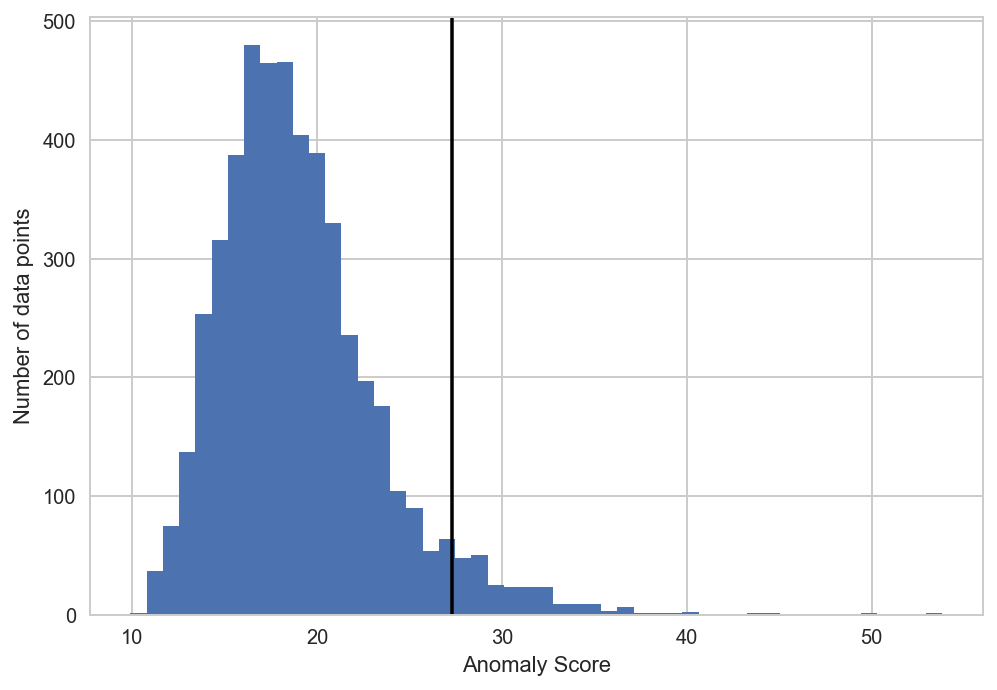

In [22]:
plt.hist(scoreOutlier, bins=50)
plt.axvline(detector.threshold_, c='k')
plt.xlabel('Anomaly Score')
plt.ylabel('Number of data points')
plt.show()

In [25]:
reducer = PCA(n_components=3)
reducer.fit(dfWine)
projection = reducer.transform(dfWine)

dfProjection = pd.DataFrame(data=projection, columns=['PC1', 'PC2', 'PC3'])
dfProjection = dfProjection.assign(flagOutlier=flagOutlier, probOutlier=probOutlier)

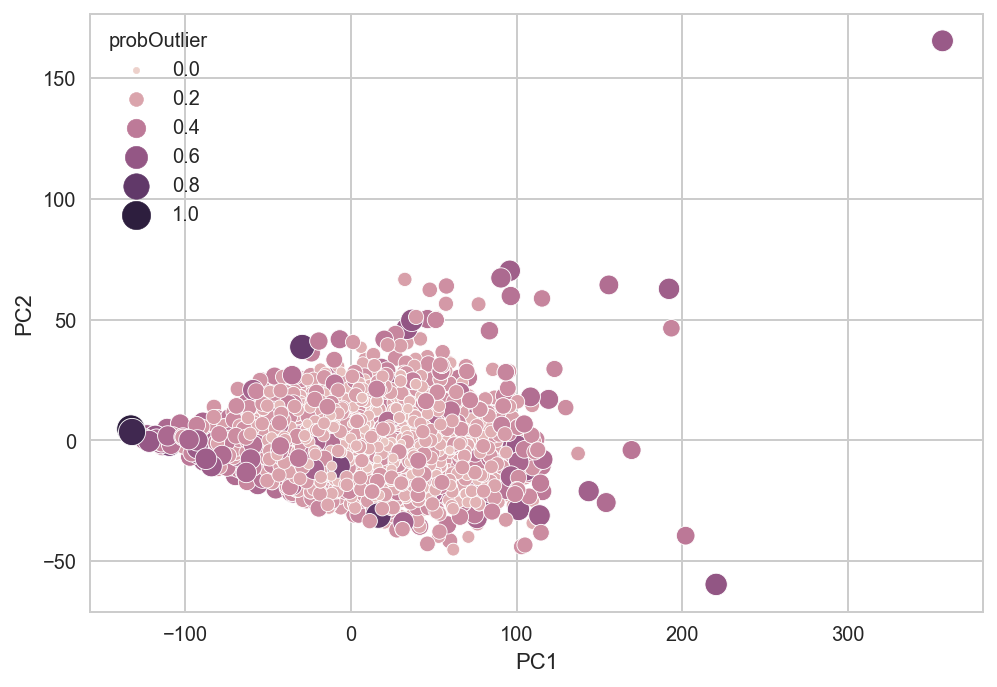

In [26]:
sns.scatterplot(
    data=dfProjection,
    x='PC1',
    y='PC2',
    hue='probOutlier',
    size='probOutlier',
    sizes=(10, 200)
)
plt.show()

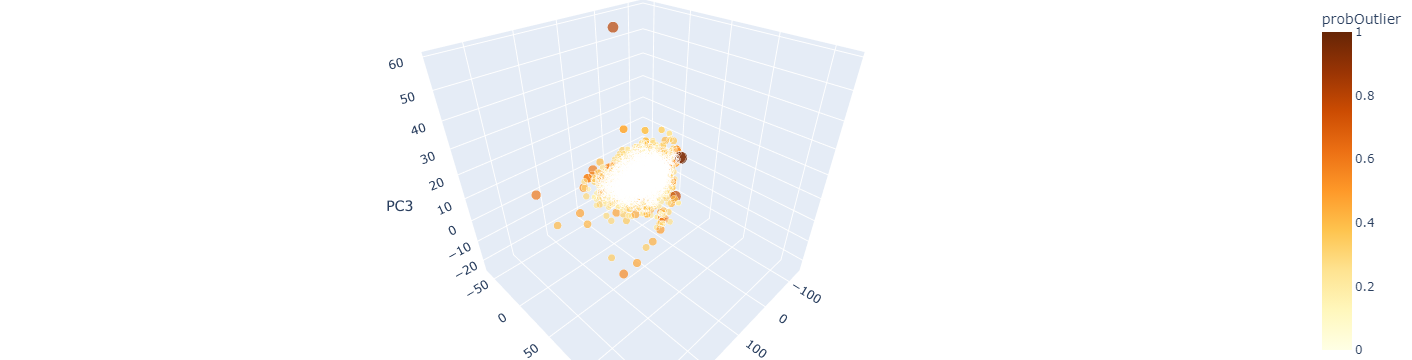

In [40]:
fig = px.scatter_3d(
    dfProjection,
    x='PC1',
    y='PC2',
    z='PC3',
    color='probOutlier',
    size='probOutlier',
    color_continuous_scale='YlOrBr'
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

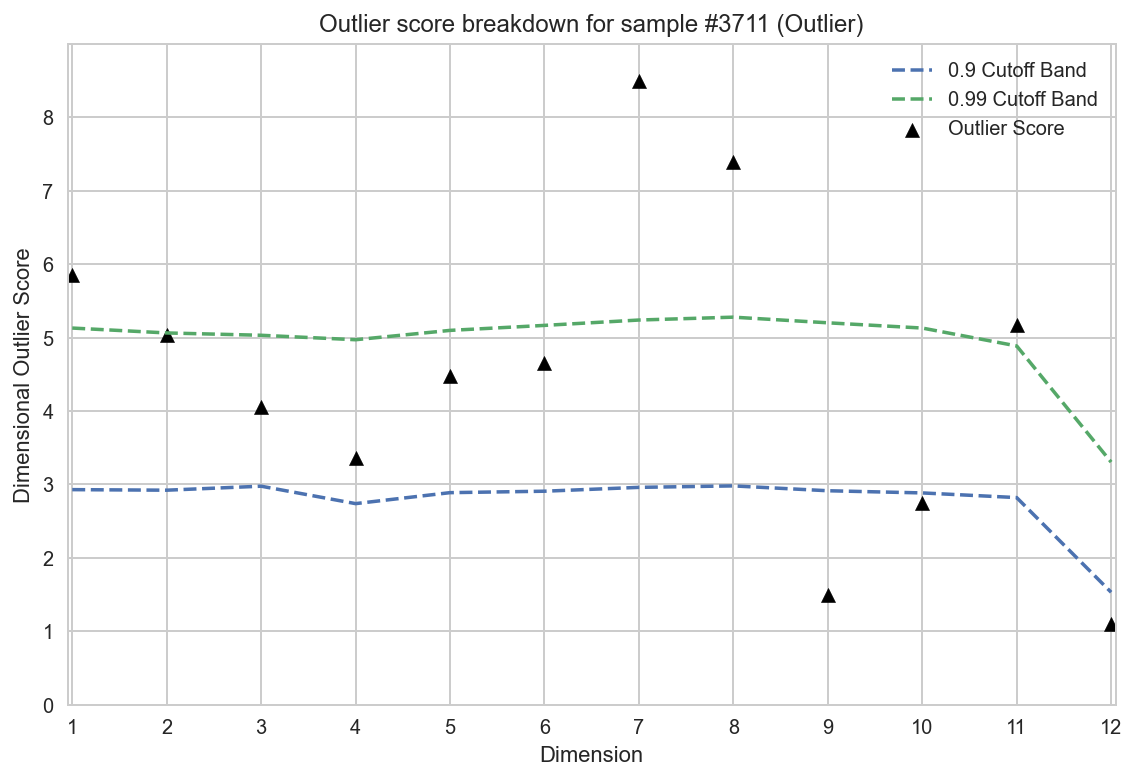

In [41]:
idxOutlier = detector.decision_scores_.argmax()
ecod.explain_outlier(idxOutlier)

## 2. Linear models
These algorithms rely on linear models to compute outlier scores.

### 2.1. PCA
As far as we know, [PCA] is a technique which breaks down a matrix into vectors called principal components, then reconstruct the original data using only the first few most important components. This low dimensional space capture most variance in the data, meaning reconstructed points are very close to the principal components. However, as outliers differ from normal data, this statement may not be true. This insight is the key idea behind applying PCA in outlier detection: the outlier score for an observation will be obtained as the total of projected distances from that sample to all eigenvectors.

The implementation of this algorithm [`PCA`] has the following hyperparameters:
- `n_selected_components`: the number of principal components involving in calculating outlier scores, defaults to *None* (use all components).
- `weighted`: whether to use weighted sum in outlier score, where eigenvalues are the weights for their corresponding eigenvectors. Defaults to *True*.

[PCA]: https://en.wikipedia.org/wiki/Principal_component_analysis
[`PCA`]: https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.pca.PCA

### 2.2. One-class SVM
In classification, [SVM] is originally designed for binary problems; the main idea is to learn a *hyperplane* that is able to separates two classes $1$ and $-1$ with maximum margin. If we treat the dataset as a single class, then SVM can be used to learn a function assigning $1$ to a small region that captures most of the data points and $-1$ elsewhere (outlier). This function only works if it was trained on normal data only - no outlier included, so this is considered a novelty detection method rather than outlier detection. There are two algorithms using this approach:
- [One-Class SVM] (OCSVM), aiming to learn a *hyperplane* separating *most* data point from the origin with maximum margin.
- [Support Vector Data Description] (SVDD), aiming to learn a *hypersphere* encompassing *most* data points with minimum volume.

The PyOD class [`OCSVM`] implements the first algorithm with the following hyperparameters:
- `nu`: the parameter $\nu$ maintaining the allowance of misclassification (soft margin), being equivalant to $C$ in original SVM. Defaults to *0.5*, must be between *0* and *1*.
- `kernel`, `gamma`, `coef0` and `degree`: parameters of the kernel function, same usage as in original SVM.

[SVM]: https://en.wikipedia.org/wiki/Support_vector_machine
[One-Class SVM]: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.675.575&rep=rep1&type=pdf
[Support Vector Data Description]: https://link.springer.com/content/pdf/10.1023/B:MACH.0000008084.60811.49.pdf
[`OCSVM`]: https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.ocsvm.OCSVM

## 3. Proximity-based
Also known as neighborhood-based, this approach assumes that outliers are far away from their neighbors. Most of them are computationally slow due to the calculation of distances.

### 3.1. KNN
The idea is very simple: aggregating distances from a data point to its $K$ nearest neighbors to get outlier score. The larger distance from a point to its neighbors, the more likely to be an outlier it is. The class [`KNN`] has the following hyperparameters:
- `n_neighbors`: the number of neighbors considered, defaults to *5*.
- `method`: the aggregate function to summarize outlier scores, defaults to *largest*. Other options are *mean* and *median*.
- `metric`: the metric for distance computation. Defaults to *minkowski*, can also accepts many other metrics.

[`KNN`]: https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.knn.KNN

### 3.2. Clustering-based
Not only DBSCAN, but any clustering algorithm can be utilized for anomaly detection - this is the main idea behind [Clustering Based Local Outlier Factor] (CBLOF). Let's say a clustering algorithm returns $K$ clusters for our dataset
$\text{C}=\{\mathcal{C}_1,\mathcal{C}_2,\dots,\mathcal{C}_K\}$
(sorted by decreasing cluster size), CBLOF aims to split them into small and large clusters. We denoted
$\text{LC}=\{\mathcal{C}_1,\mathcal{C}_2,\dots,\mathcal{C}_B\}$
the set of large clusters and
$\text{SC}=\{\mathcal{C}_{B+1},\mathcal{C}_{B+2},\dots,\mathcal{C}_K\}$
the set of small clusters. With the introduction of two parameters $\alpha$ and $\beta$, the determination of $\text{SC}$ and $\text{LC}$ must satisfy one of the two conditions:
- The ratio of observations in large clusters is at least $\alpha$ (usually $90\%$):
$|\mathcal{C}_1|+|\mathcal{C}_2|+\ldots+|\mathcal{C}_B|\geq\alpha N$
- All large clusters must be at least $\beta$ (usually $5$) times larger than small clusters:
$|\mathcal{C}_{B}|\geq\beta|\mathcal{C}_{B+}|$

The anomaly score for a sample is then computed as the product of (1) the distance between the sample and the nearest centroid of a large cluster and (2) the size of the cluster it belongs to. The intuition behind the first term is we are viewing small clusters as groups of potential outliers, making their centroids carry no meaning. As the result, we use centroids of large clusters instead, but this distance will be very high for samples in small clusters. This leads us to the multiplication with the second term, it can be thought as a compensation for small clusters.

This algorithm is implemented via the class [`CBLOF`] with the hyperparameters:
- `clustering_estimator`: the clustering algorithm to be used, defaults to *None* (using K-Means). It accepts an instance returned by Scikit-learn clustering classes.
- `n_clusters`: the number of clusters, defaults to *8*.
- `alpha`: the value of $\alpha$, defaults to *0.9*.
- `beta`: the value of $\beta$, defaults to *5*.

[Clustering Based Local Outlier Factor]: https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=d8021847ed0e3f26b53416c2a254a85451ee5f1e
[`CBLOF`]: https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.cblof.CBLOF

### 3.3. Local Outlier Factor
[Local Outlier Factor] (LOF) is a popular algorithm with the basic idea is to compare local density of an observation versus local density of its neighbors. The method for defining density is quite similar to DBSCAN. With a pre-selected value of $K$ (number of nearest neighbors), the algorithm follows these steps:
- *Step 1*: Define the $K$-distance for every sample $\mathbf{p}_i$ in the dataset being the distance from it to the $K^{th}$ nearest neighbor, denoted $\text{KD}_i$.
- *Step 2*: Compute the so-called *reachability distance* from a core point $\mathbf{p}_i$ to each of its neighbor $\mathbf{p}_k$ (for $k=1,2,\dots,K$). It is just the distance between the two points (denoted $d_{ik}$), but is replaced with $\text{KD}_k$ when they are too close. This calculation works as a smoothing strategy ensuring the distance is not too small, which produce fluctuations as we are going to use the inverse of it later.

$$\text{RD}_{ik}=\max(\text{KD}_k,d_{ik})$$

- *Step 3*: Compute the *local reachability density* for the core point $\mathbf{p}_i$

[Local Outlier Factor]: https://en.wikipedia.org/wiki/Local_outlier_factor

[LOF](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.lof) is widely uses in anomaly detection specially for local outlier. It computes the local density deviation of a given data point with respect to its neighbors. A point will be considered as outlier when it has a significantly lower density than it neighbors. In other word, LOF compares the local density of a point to local density of its k-nearest neighbors and gives a score as final output. The disadvantage of LOF or proximity-based algorithms is it costs time very much to calculate the distance between large data points.

The process of LOF follow these step:
- Determined the distance from data point $p_i$ to $k_{th}$ nearest neighbors (pyod support all distance metrics from sklearn and scipy). Get the max distance among $k$ points - this is called *K_distance*. The number of neighbors of $p_i$ can greater or equal $k$ due to the distance between them - denote $|N_p|$ 
- Computes the *reachability density (RD)* of each $p_i$ related to others. RD is defined as the maximum of K-distance of $p_i$ and the distance between $p_i$ and $p_j$:

$$\text{RD}(p_i,p_j) = \max(\text{K_distance}_{p_i}, d(p_i,p_j))$$

:::{image} ../image/local_outlier_factor.png
:height: 250px
:align: center
:::
<br>

- Computes the *local reachability density (LRD)*. LRD is inverse of the average RD of $p_i$ from its neighbors. The larger average RD leads to the smaller LRD - it means the density of $p_i$ is quite low:

$$\text{LRD}_{p_i}= \frac{1}{\sum_{p_j \in N_p}\frac{\text{RD}(p_i,p_j)}{|N_p|} } $$

- Calculates the *LOF score* for each $p_i$ - LOF score is the ratio of the average LRD of the $K$ neighbors of $p_i$ to the LRD of $p_i$. If a point is inliner, the LRD of this point is approximately equal to its neighbors that leads to LOF is nearly equal to 1. On the other hand, if the point is an outlier, the LRD of a point is less than the average LRD of neighbors, then LOF value will be high:

$$\text{LOF}_{p_i} = \frac{\sum_{p_j \in N_p} \text{LRD}_{p_j}}{|N_p|} \cdot \frac{1}{\text{LRD}_{p_i}}$$

#### Connectivity-based
[COF](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cof) (Connectivity-based Outlier Factor) is another version of LOF. In LOF, the theory is that data points are distributed in circle around the instance, but in the case there is a linear relationship between data points, the distance metric in LOF is no longer correct. COF calculates the anomaly score based on average *chain distance* between points and their neighbors. Therefore, COF is suitable for local and dependency outliers but like LOF, the time cosuming of COF is quite high with large dataset.

As same as LOF, COF firstly find $k$ nearest neighbors of point $p$ then arrange them in order of closest distance to $p$. Call $e_k$ is the *edge distance*, equals to each pair of points distance, example $e_2$ is the distance between $P_2$ and $P_3$, we calculates average chain distance for each instance:

$$\text{ACD}_p = \sum_{i=1}^k \frac{2(k+1-i)}{k(k+1)} e_i$$

:::{image} ../image/connectivity_based_outlier_factor.png
:height: 180px
:align: center
:::
<br>

At last, anomaly score is generated by ratio of average chaining distance of instance and the average of average chaining distance of $k$ nearest neighbor of this point. The higher the score, the easier it is to be an outlier.

$$\text{COF}_p = \frac{\text{ACD}_p}{\frac{\sum ACD_k}{k}}$$

## 4. Probabilistic
This method constructs the empirical distribution of the dataset then predict the tail probabilities of each given data point to determine its level of *extremeness*.

### (w) 4.1. ECOD

### 4.2. COPula-based
[COPOD](https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.copod.COPOD) (COPula-based Outlier Detection) is a parameter-free algorithm, which is built based on empirical multivariate distribution. Beside of no hyperparameters, it is also fast and computationally efficient, suitable for high-himensional data. The math behind this algorithm is quite complicated, simply understand that COPOD constructs the multivariate cumulative distribution function, and then uses it to predict tail probabilities of each given data point to determine its level of extremeness. The score in this case is not outlier probability but measuring the likelihood of a row, relative to other points in the dataset.

### 4.3. Histogram-based
The idea of HBOS (Histogram-based Outlier Score) is based on assumption that the variables are independence of each other. HBOS is constructing a histogram for each variable, then calculating the *univariate outlier score* for each observation and finally sum up to measure the outlier score of an observation. HBOS is suitable for global and clustered outliers, it also has very fast computing time - especially for large dataset.

Firstly, the algorithm will create histogram of each variable $d$. If a feature is numerical, bin it to get its histogram, if it is categorical, just count the values of each category. The height of bins ($h_d$) which data point belongs is the measure of outlier-ness. To get higher value for outlier, we inverse $h_d$ and standardize score by log transform to ensures all the univariate scores can be summed up with equal weight. The formula of outlier score of a point $p$ is very simply:

$$\text{HBOS}_p = \sum_{d=0}^D \log(\frac{1}{h_d})$$

The outliers will have a higher score than inliers points and these will be labelled 1 due to the outlier threshold we set. The challenge of HBOS is, it can be sensitive to the bin width of the histogram. If the bins are too narrow, the normal data points falling in these bins will be identified as outliers and vice versa. To produce a model with a stable outcome, the strategy is to build HBOS models with a range of histogram widths to obtain multiple scores and then aggregate the scores (by average or max average). This approach will reduce  overfitting and increase prediction accuracy. 

## 5. Black-box

### 5.1. Isolation Forest
[Isolation Forest](https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.iforest.IForest) detects the outliers based on ensembling binary decision trees to isolate outliers from the others. Relying on the characteristics of outliers are few and difference, IForest built each tree using sub-sample of dataset, then randomly seleted a feature and a random threshold to split the tree. The process of splitting continue until all instance has been isolated or the tree reach the maximum height or all same-value data points go into same node. The outliers will have short path to the root than others, especially when all tree in the forest say that. Formula of anomaly score depends on the average of path length to the root $\overline{h_p}$, number of instances in node - $n$ and unsuccesfull path in binary search tree $c(n)$:

$$\begin{aligned}
\text{iForest}_p &= 2^{-\frac{\overline{h}_p}{c(n)}} \\
c(n) &= 2 \cdot (\log(n-1)+0.577) - \frac{2(n-1)}{n} \\
\end{aligned}$$

Iforest just requires 2 params which are number of trees and sub-sample size - it works very well with small sample sizes and high-dimensional data, time consuming of this method is also fast and it can apply for all 4 types of anomaly. But iForest also has a disadvantage that a node in an iTree is split based on a threshold value, the data is split into left and right branches resulting in horizontal and vertical branch cuts - this will lead to some outliers are passed.

### (w) 5.2. Autoencoder

## Resources
- https://github.com/openvinotoolkit/anomalib
- https://github.com/SeldonIO/alibi-detect
- https://github.com/vc1492a/PyNomaly
- https://madm.dfki.de/_media/theses/bachelorthesis-amer_2011.pdf
- https://www.goldiges.de/publications/Anomaly_Detection_Algorithms_for_RapidMiner.pdf
- https://stats.stackexchange.com/questions/313857/why-one-class-svm-seperate-from-the-origin
- https://towardsdatascience.com/local-outlier-factor-lof-algorithm-for-outlier-identification-8efb887d9843
- https://medium.com/dataman-in-ai/anomaly-detection-with-histogram-based-outlier-detection-hbo-bc10ef52f23f
- https://www.goldiges.de/publications/HBOS-KI-2012.pdf
- https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest
- https://arxiv.org/pdf/2009.09463.pdf
- https://towardsdatascience.com/fast-accurate-anomaly-detection-based-on-copulas-copod-3133ce9041fa